<a href="https://colab.research.google.com/github/shivamsonawane/Sentiment-Clustering/blob/main/Topic_Modeling_and_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling on Twitter Data 

# Import Dependencies 

In [ ]:
!pip install pyldavis

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import operator
from functools import reduce
from collections import defaultdict

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from imblearn.over_sampling import RandomOverSampler
import pickle
import spacy
import ast
import os
import pyLDAvis
import pyLDAvis.gensim_models  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)

stop_words = stopwords.words('english')
len(stop_words)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# set project directory
os.chdir("/content/drive/MyDrive/Sentiment_Project")

# get all stop words 
stop_words = stopwords.words('english')
print(len(stop_words))

# extend stopwords
file = open("DATA/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()
print(len(stop_words))


179
1527


In [ ]:
# read data
df1 = pd.read_excel("DATA/ukraine_tweets_sample_copy1.xlsx")
df2 = pd.read_excel("DATA/ukraine_tweets_sample_copy2.xlsx")
df3 = pd.read_excel("DATA/ukraine_tweets_sample_copy3.xlsx")

# concat all data files and remove irrelevent label
df = pd.concat([df1, df2, df3], axis=0)
df = df[df["Stance Label"]!="Irrelevant"].reset_index(drop=True)
print(df.shape)
df.head(10)

(4177, 4)


,id_str,created_at,full_text,Stance Label
0,1497026099494023173,2022-02-25 01:50:10,"Russian Rosgvardia troops, likely spetsnaz, cr...",Neutral
1,1497258644987002880,2022-02-25 17:14:13,@WrestlingWombat @HStefansonMB What is happeni...,ProUkraine
2,1497872993732628484,2022-02-27 09:55:25,Today on the campaign trail I had some tough c...,ProUkraine
3,1499163764951818241,2022-03-02 23:24:29,"ICYMI: n light of Russia sanctions, Fed chair ...",Neutral
4,1499467511087222789,2022-03-03 19:31:28,By now over a thousand refugees from #Ukraine ...,ProUkraine
5,1508139059427819522,2022-03-27 17:49:06,Whoever is coming up with reactive strategy by...,ProRussia
6,1508675556358774786,2022-03-29 05:20:57,He also writes about the possibility of Ukrain...,ProUkraine
7,1512504441324322834,2022-04-08 18:55:34,"At Horizon, we are deeply concerned and sadden...",ProUkraine
8,1515578470755192837,2022-04-17 06:30:40,#UkraineUnderAttack Join us in this Democracy ...,ProUkraine
9,1516846493637951489,2022-04-20 18:29:20,@RALee85 Russian tanks in cities where they’re...,ProUkraine


# Data preprocessing

In [ ]:
# Convert to list
data = df.full_text.values.tolist()
print(len(data))

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

# preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)# higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



4177


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
%%time 

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpusa
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

CPU times: user 22.1 s, sys: 137 ms, total: 22.2 s
Wall time: 22.6 s


# Model Builidng

In [ ]:
START = 2
STOP = 15
STEP = 1


In [ ]:
def tune_model(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)

        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts,
                                        dictionary=dictionary, 
                                        coherence='c_v')
        
        coherence_values.append(round(coherencemodel.get_coherence(),3))

    return model_list, coherence_values


# Can take a long time to run
model_list, coherence_values = tune_model(dictionary=id2word, 
                                          corpus=corpus, 
                                          texts=data_lemmatized, 
                                          start=START, 
                                          limit=STOP, 
                                          step=STEP)

100%|██████████| 13/13 [02:08<00:00,  9.91s/it]


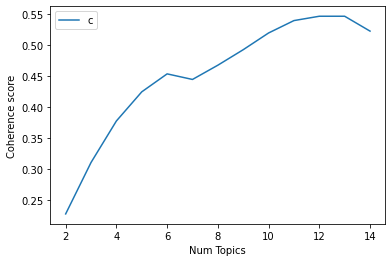

In [ ]:
# Show graph
limit=STOP; start=START; step=STEP;
x = range(START, STOP, STEP)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.223
Num Topics = 3  has Coherence Value of 0.306
Num Topics = 4  has Coherence Value of 0.346
Num Topics = 5  has Coherence Value of 0.433
Num Topics = 6  has Coherence Value of 0.438
Num Topics = 7  has Coherence Value of 0.489
Num Topics = 8  has Coherence Value of 0.524
Num Topics = 9  has Coherence Value of 0.49
Num Topics = 10  has Coherence Value of 0.498
Num Topics = 11  has Coherence Value of 0.483
Num Topics = 12  has Coherence Value of 0.51
Num Topics = 13  has Coherence Value of 0.552
Num Topics = 14  has Coherence Value of 0.56


In [ ]:
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


x = optimal_model.show_topics(num_topics=8, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
print()

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(str(topic) + "::" + str(words))
    print()
print()

print("---------------------")

[(0,
  '0.076*"ukrainian" + 0.066*"ukraine" + 0.058*"people" + 0.028*"support" + '
  '0.027*"war" + 0.027*"russian" + 0.016*"send" + 0.015*"weapon" + '
  '0.012*"https" + 0.012*"soldier"'),
 (1,
  '0.026*"invasion" + 0.022*"work" + 0.021*"trump" + 0.016*"attack" + '
  '0.015*"fact" + 0.015*"kyiv" + 0.015*"https" + 0.014*"join" + 0.014*"peace" '
  '+ 0.012*"city"'),
 (2,
  '0.039*"nuclear" + 0.023*"sanction" + 0.018*"war" + 0.017*"civilian" + '
  '0.014*"russian" + 0.013*"region" + 0.013*"hit" + 0.011*"arm" + 0.011*"read" '
  '+ 0.010*"pay"'),
 (3,
  '0.052*"nazi" + 0.037*"call" + 0.016*"big" + 0.015*"vote" + 0.014*"refugee" '
  '+ 0.014*"guy" + 0.014*"time" + 0.013*"criminal" + 0.012*"shit" + '
  '0.012*"child"'),
 (4,
  '0.021*"happen" + 0.020*"power" + 0.018*"shell" + 0.017*"wrong" + '
  '0.016*"military" + 0.015*"win" + 0.015*"claim" + 0.014*"https" + '
  '0.014*"zelensky" + 0.013*"long"'),
 (5,
  '0.063*"propaganda" + 0.027*"country" + 0.015*"medium" + 0.015*"lose" + '
  '0.013*"go

# Prediction

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Topic_No', 'Topic_Perc_Contrib', 'Topic_Keywords', 'Text']

final_df = df_dominant_topic.drop("Document_No", axis=1)

# add clean text Show
clean_text = [ " ".join(i) for i in texts]
final_df["Clean_Text"] = clean_text

# show
final_df.head(10)

<ipython-input-16-d2154aa7e630>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-16-d2154aa7e630>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Topic_No,Topic_Perc_Contrib,Topic_Keywords,Text,Clean_Text
0,7,0.6534,"russian, kill, year, war, lie, troop, invade, ...","Russian Rosgvardia troops, likely spetsnaz, cr...",russian rosgvardia troop spetsnaz cross lheqwvq
1,3,0.4487,"nazi, call, big, vote, refugee, guy, time, cri...",What is happening in Ukraine is affecting all ...,happen accept time fear stand defend innocent ...
2,1,0.7784,"invasion, work, trump, attack, fact, kyiv, htt...",Today on the campaign trail I had some tough c...,campaign trail tough conversation people vacci...
3,3,0.6551,"nazi, call, big, vote, refugee, guy, time, cri...","ICYMI: n light of Russia sanctions, Fed chair ...",icymi call legislative framework illicit knsq
4,3,0.7351,"nazi, call, big, vote, refugee, guy, time, cri...",By now over a thousand refugees from #Ukraine ...,refugee reach include child greet kid soft toy...
5,2,0.6816,"nuclear, sanction, war, civilian, russian, reg...",Whoever is coming up with reactive strategy by...,come reactive strategy back corner nuclear opt...
6,4,0.6158,"happen, power, shell, wrong, military, win, cl...",He also writes about the possibility of Ukrain...,write possibility join judge find incomparably...
7,5,0.7170,"propaganda, country, medium, lose, government,...","At Horizon, we are deeply concerned and sadden...",horizon deeply concerned sadden ongoing confli...
8,1,0.6353,"invasion, work, trump, attack, fact, kyiv, htt...",#UkraineUnderAttack Join us in this Democracy ...,join democracy connect support concern brutal ...
9,1,0.4679,"invasion, work, trump, attack, fact, kyiv, htt...",Russian tanks in cities where they’re not want...,russian tank city want


In [ ]:
final_df["Topic_No"].value_counts()

0    956
1    524
5    482
7    476
6    476
3    444
2    436
4    383
Name: Topic_No, dtype: int64

In [ ]:
final_df.to_csv("DATA/output1.csv", index=False)

# Topic Modeling Visualisation

## 1. The most representative sentence for each topic

Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8334,"ukrainian, ukraine, people, support, war, russian, send, weapon, https, soldier","Pedo peter picked a pack of cracking pipers, a pack of cracking pipers pedo peter picked, now if..."
1,1,0.7784,"invasion, work, trump, attack, fact, kyiv, https, join, peace, city",Today on the campaign trail I had some tough conversations with people about vaccine mandates [s...
2,2,0.8263,"nuclear, sanction, war, civilian, russian, region, hit, arm, read, pay","His student status enabled temporary deferment of military service during the Second World War, ..."
3,3,0.7864,"nazi, call, big, vote, refugee, guy, time, criminal, shit, child",The European Commission will consider a strategy on Wednesday that would address technical and b...
4,4,0.7042,"happen, power, shell, wrong, military, win, claim, https, zelensky, long",https://t.co/KvSl0VFP9F : Vengeful Putin blitzes Ukraine power stations plunging 9million into d...
5,5,0.8280,"propaganda, country, medium, lose, government, find, supply, understand, western, time","Rejecting Finland, Sweden based on their liberal ideology and open society, is intervention into..."
6,6,0.7393,"money, fight, day, https, bad, hold, country, news, death, state",The #RussiaUkraineConflict has prompted another round of #Russiansanctions by the United States....
7,7,0.7639,"russian, kill, year, war, lie, troop, invade, missile, life, land","heck, the P90 and the MP7 were designed in the cold-war explicitly for rear-echelon troop to man..."


## 2. Frequency Distribution of Word Counts in Documents
When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

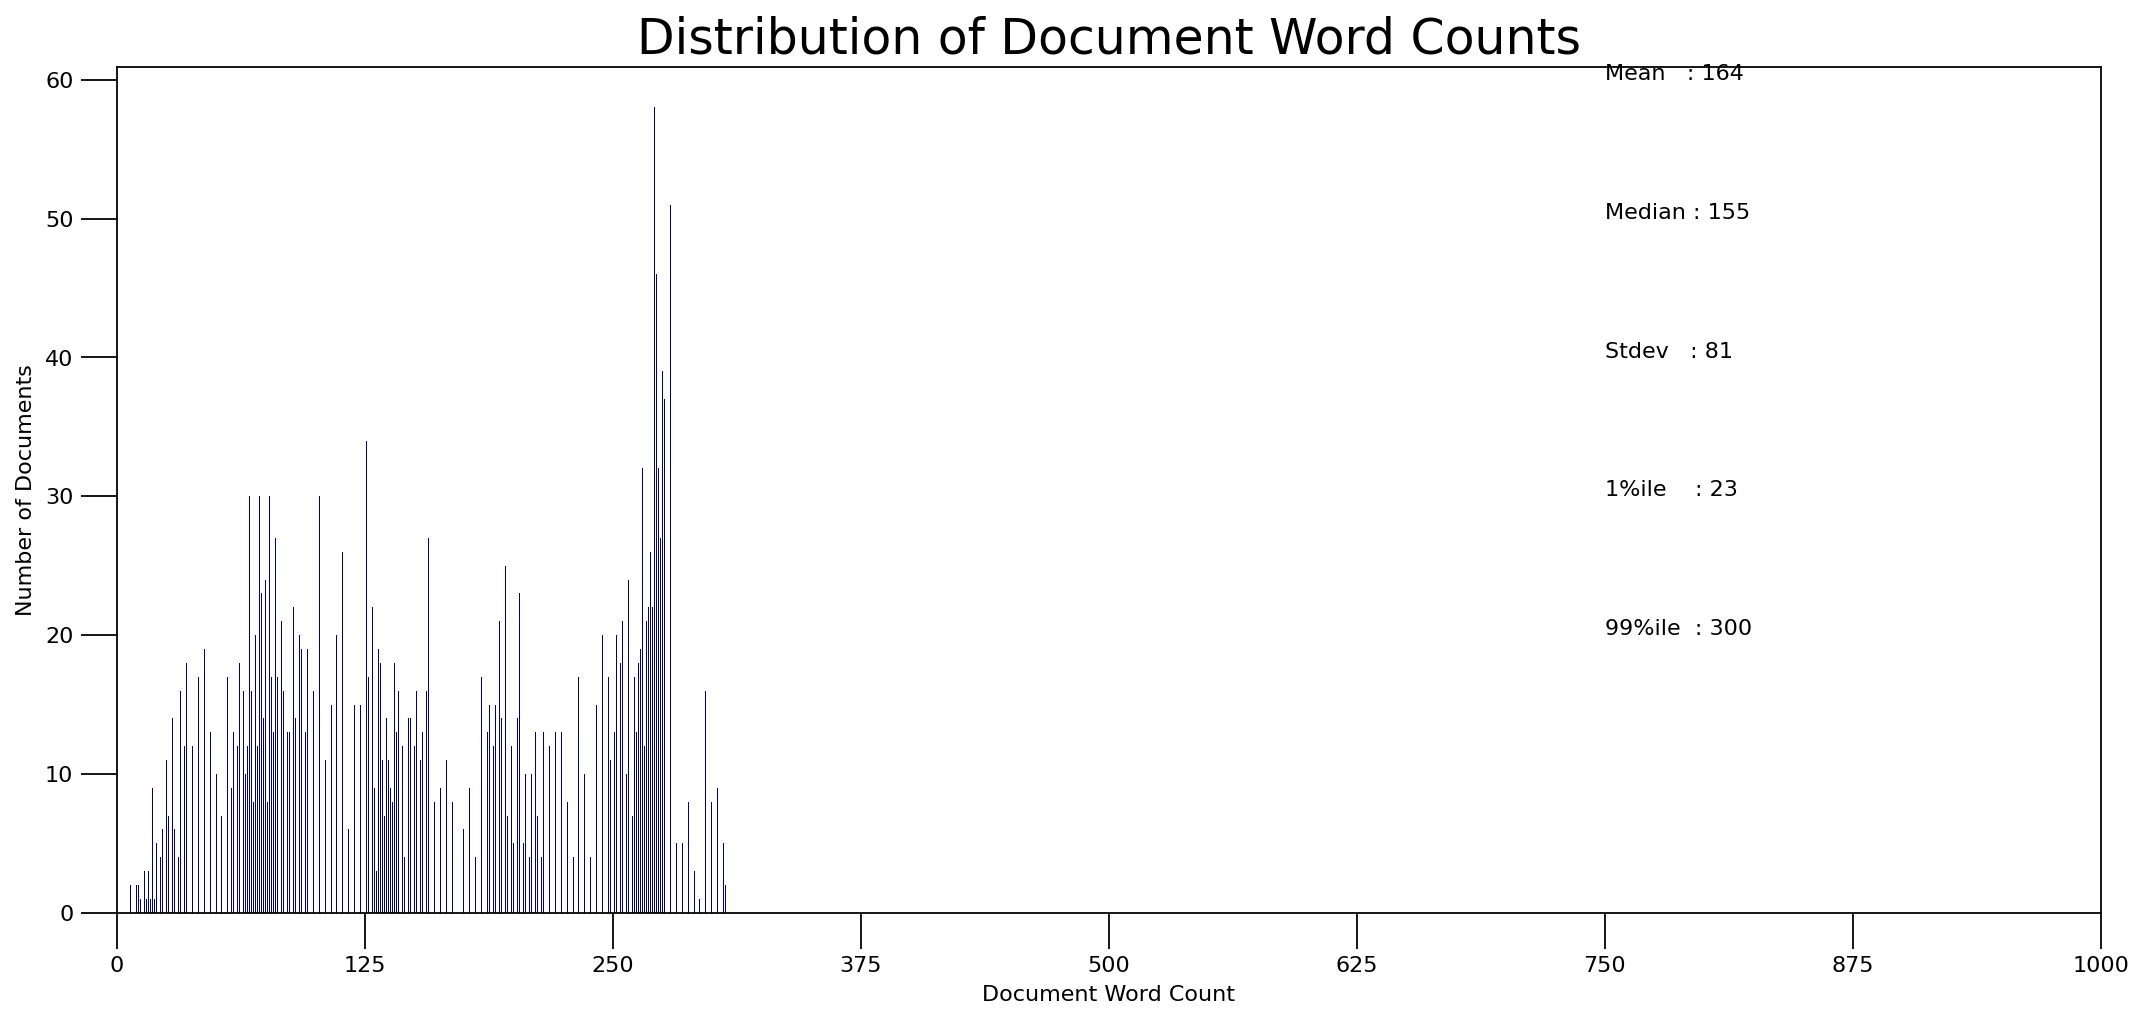

In [ ]:
doc_lens = [len(d) for d in final_df.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 60, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  50, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  40, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  30, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

<ipython-input-27-79a66c960fe8>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-27-79a66c960fe8>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-27-79a66c960fe8>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
<ipython-input-27-79a66c960fe8>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(doc_lens, col

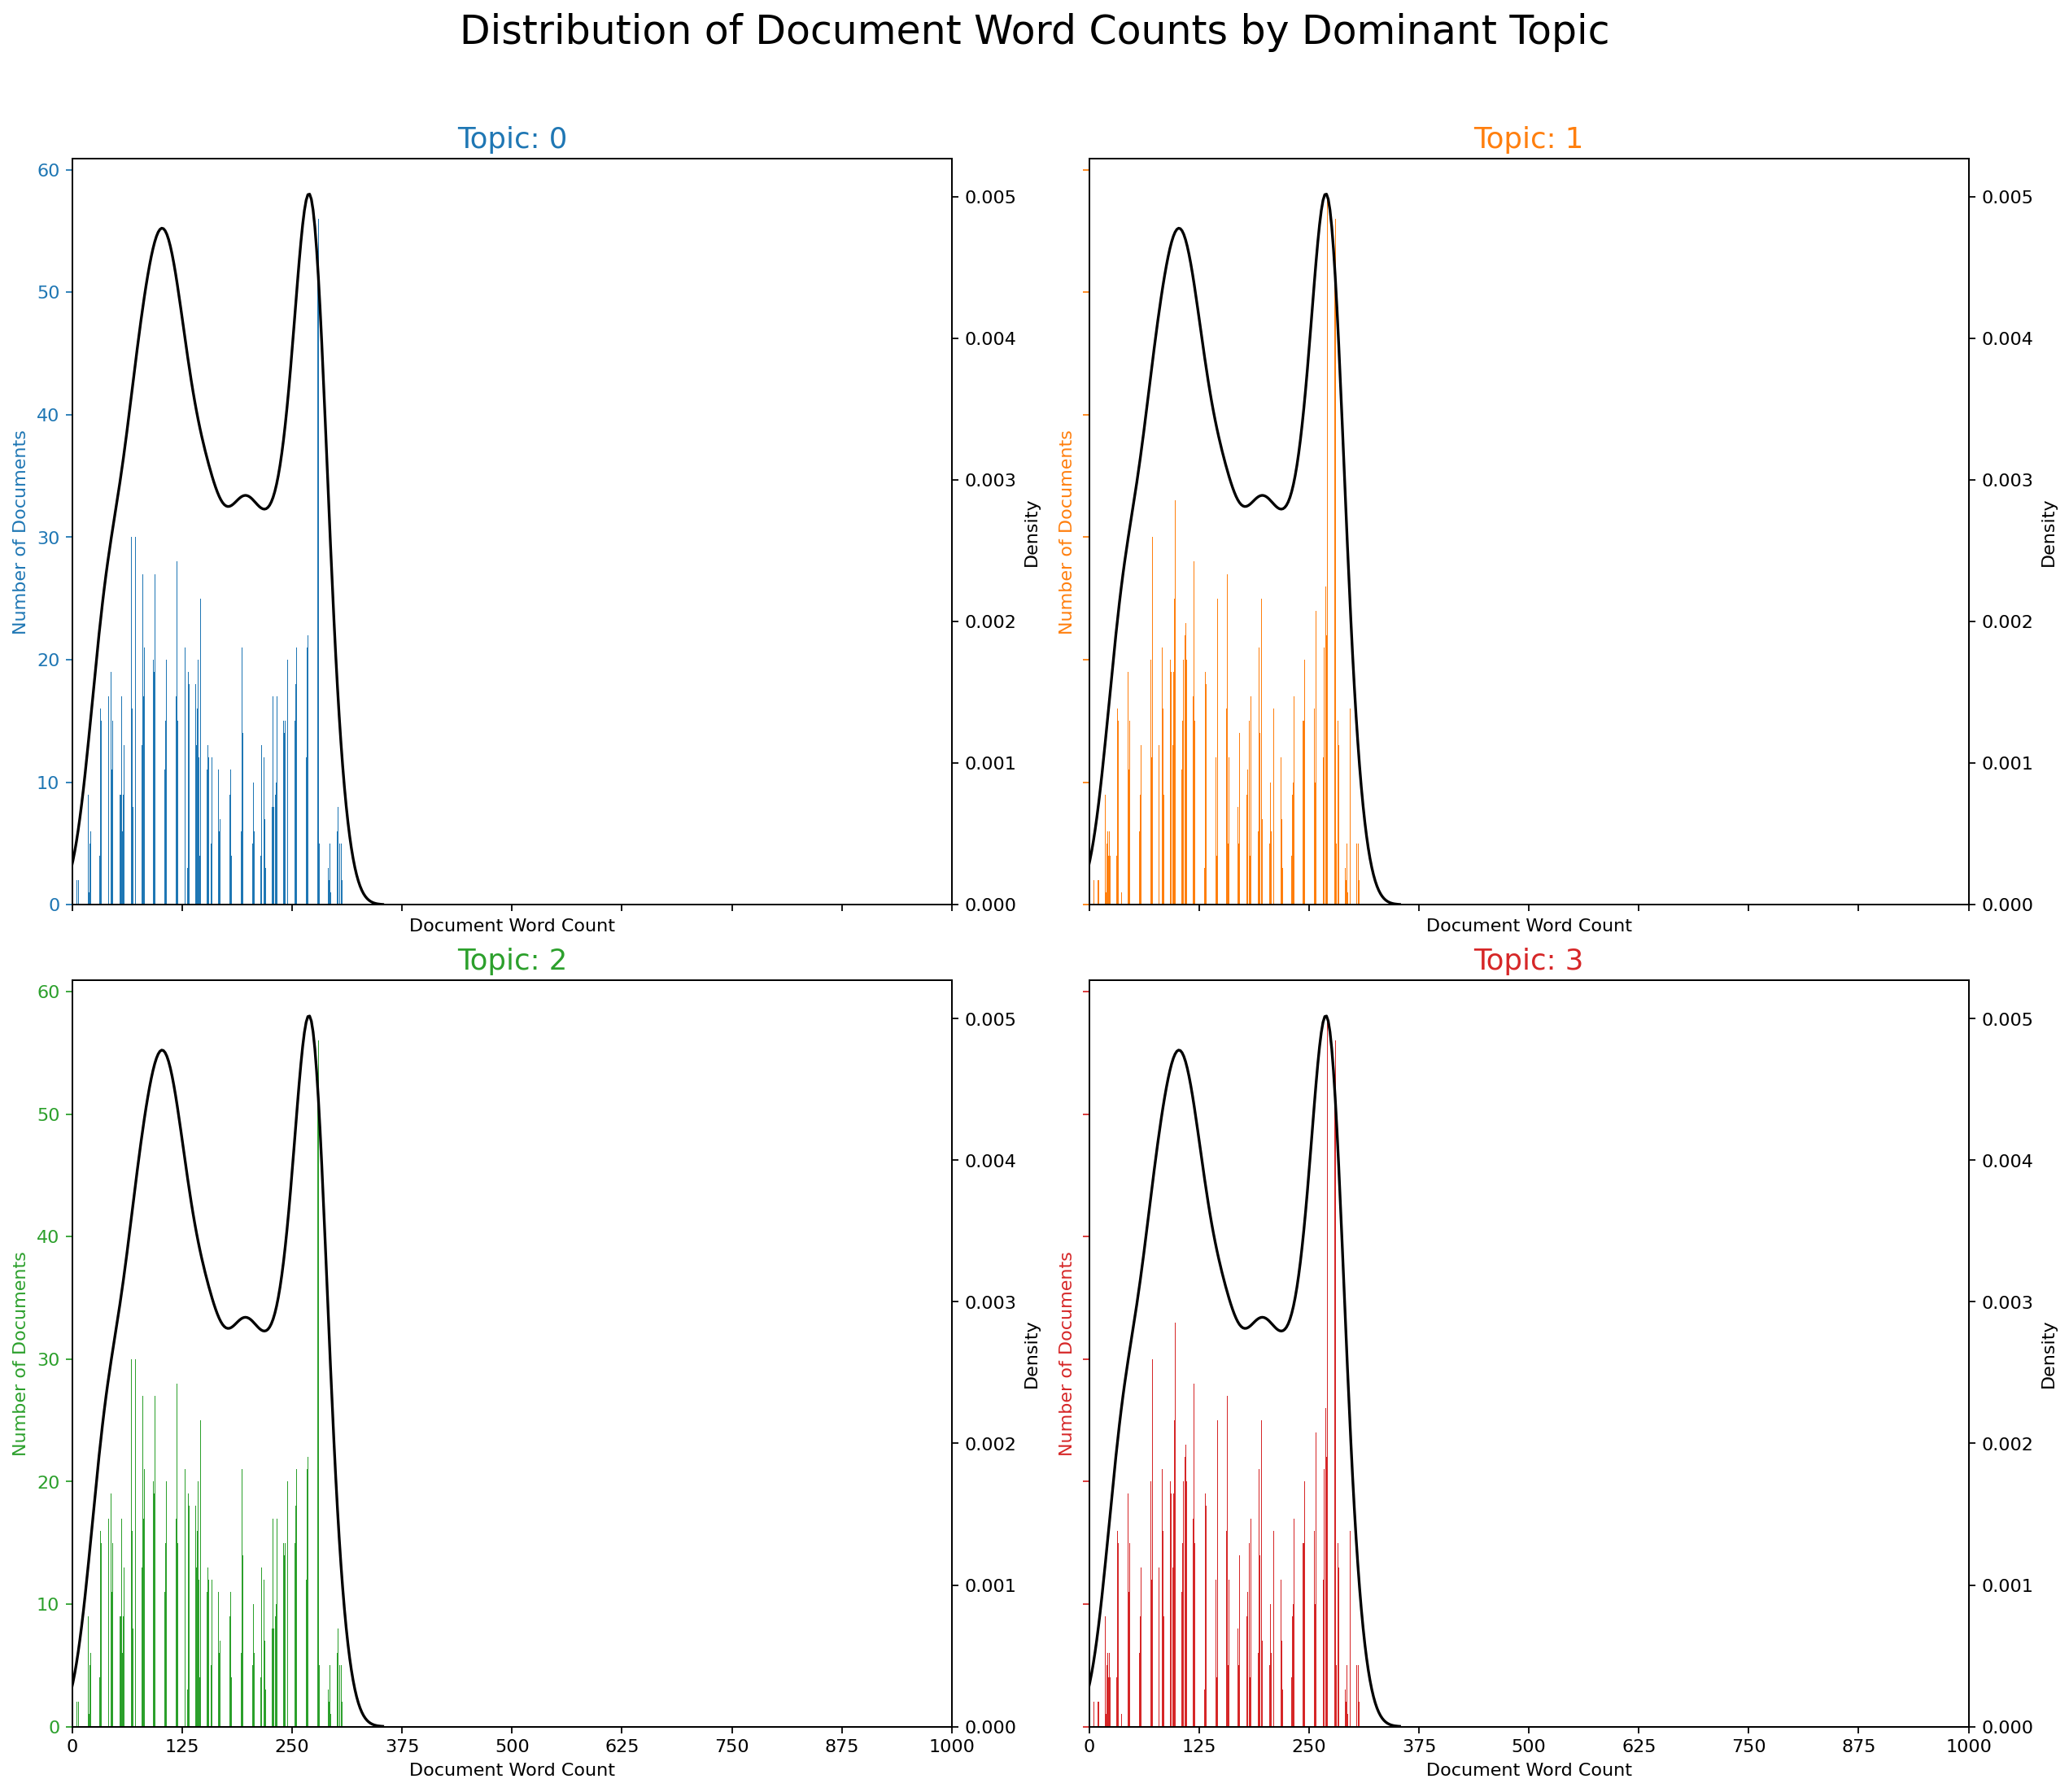

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = final_df.loc[final_df.Topic_No == i, :]
    doc_lens = [len(d) for d in final_df.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## 3. Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

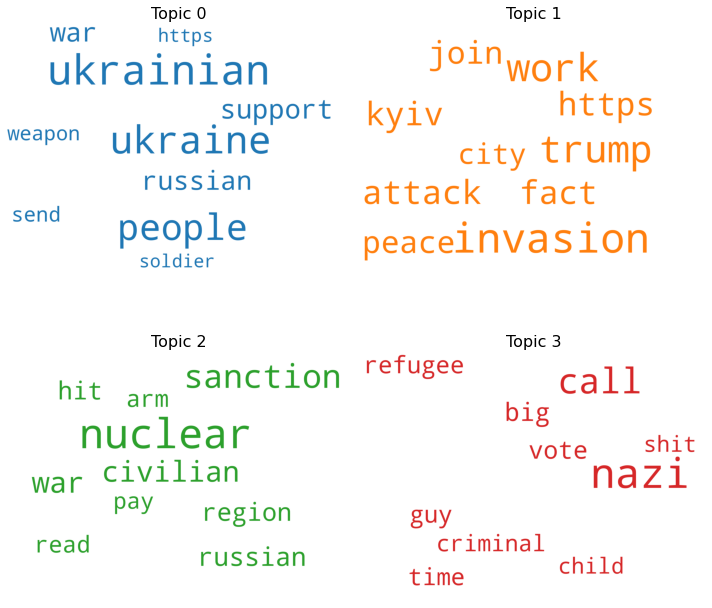

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## 4. Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

<ipython-input-32-edb94289fe79>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


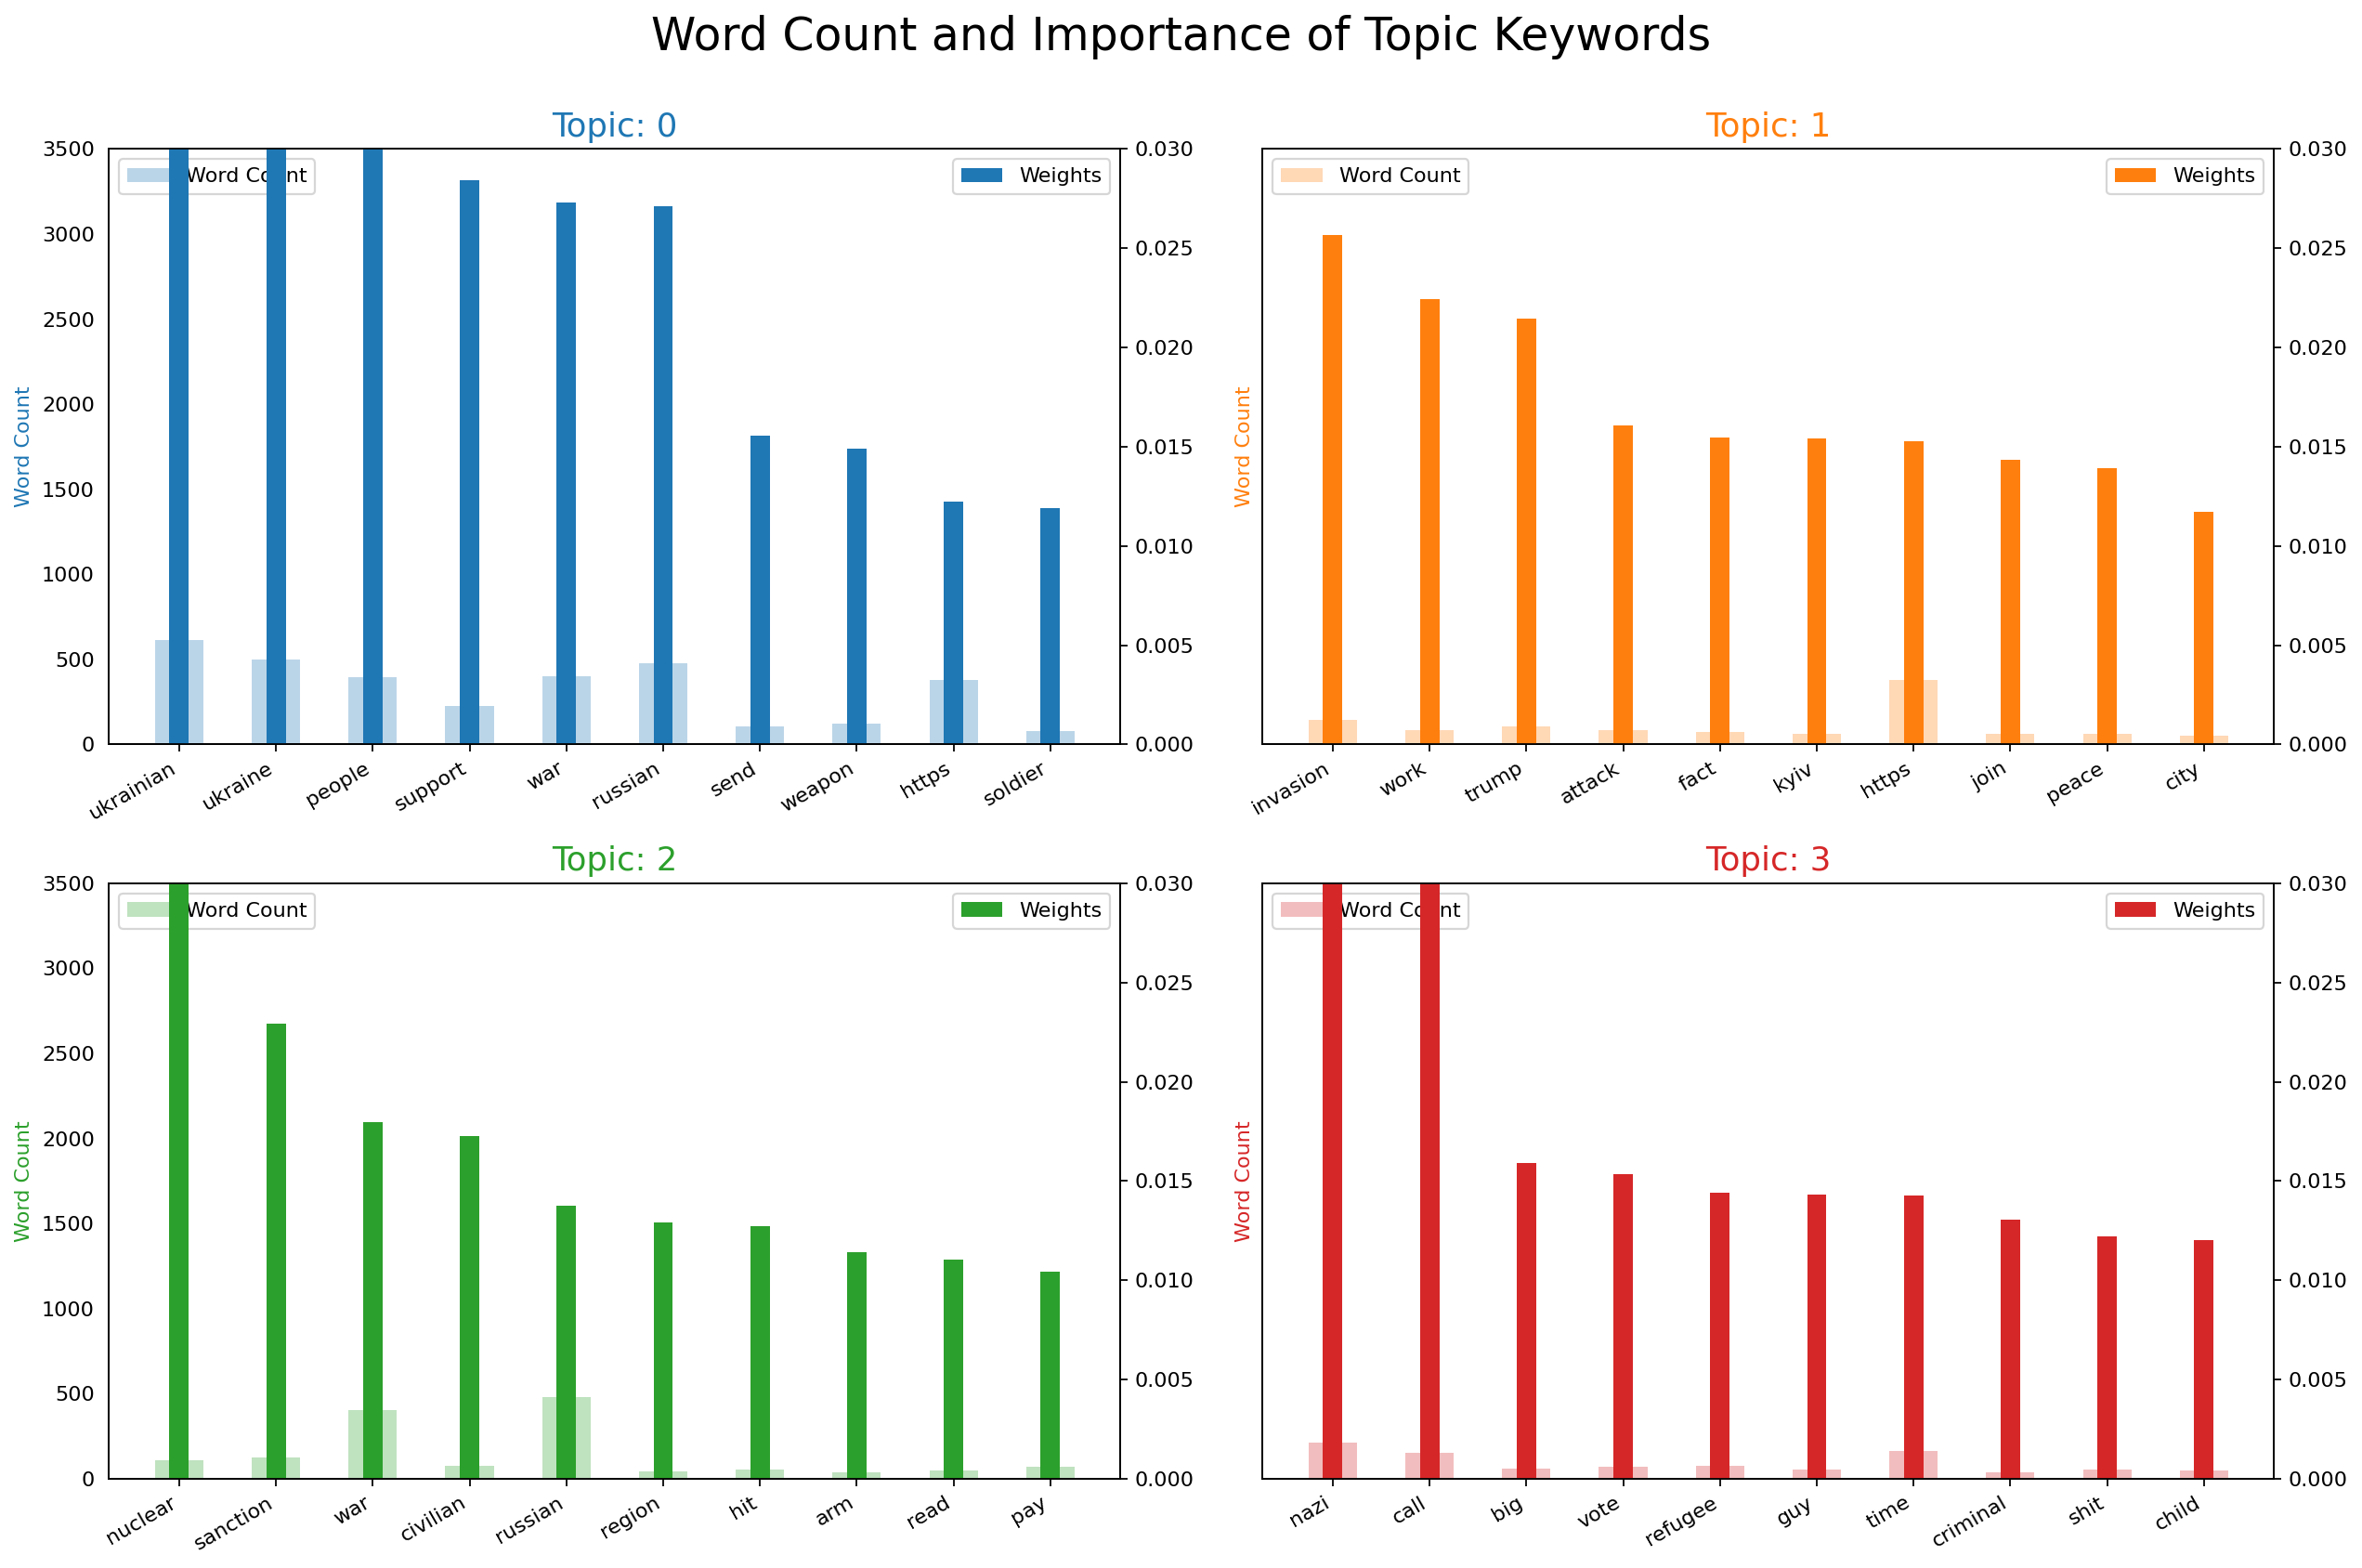

In [ ]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## 5. Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

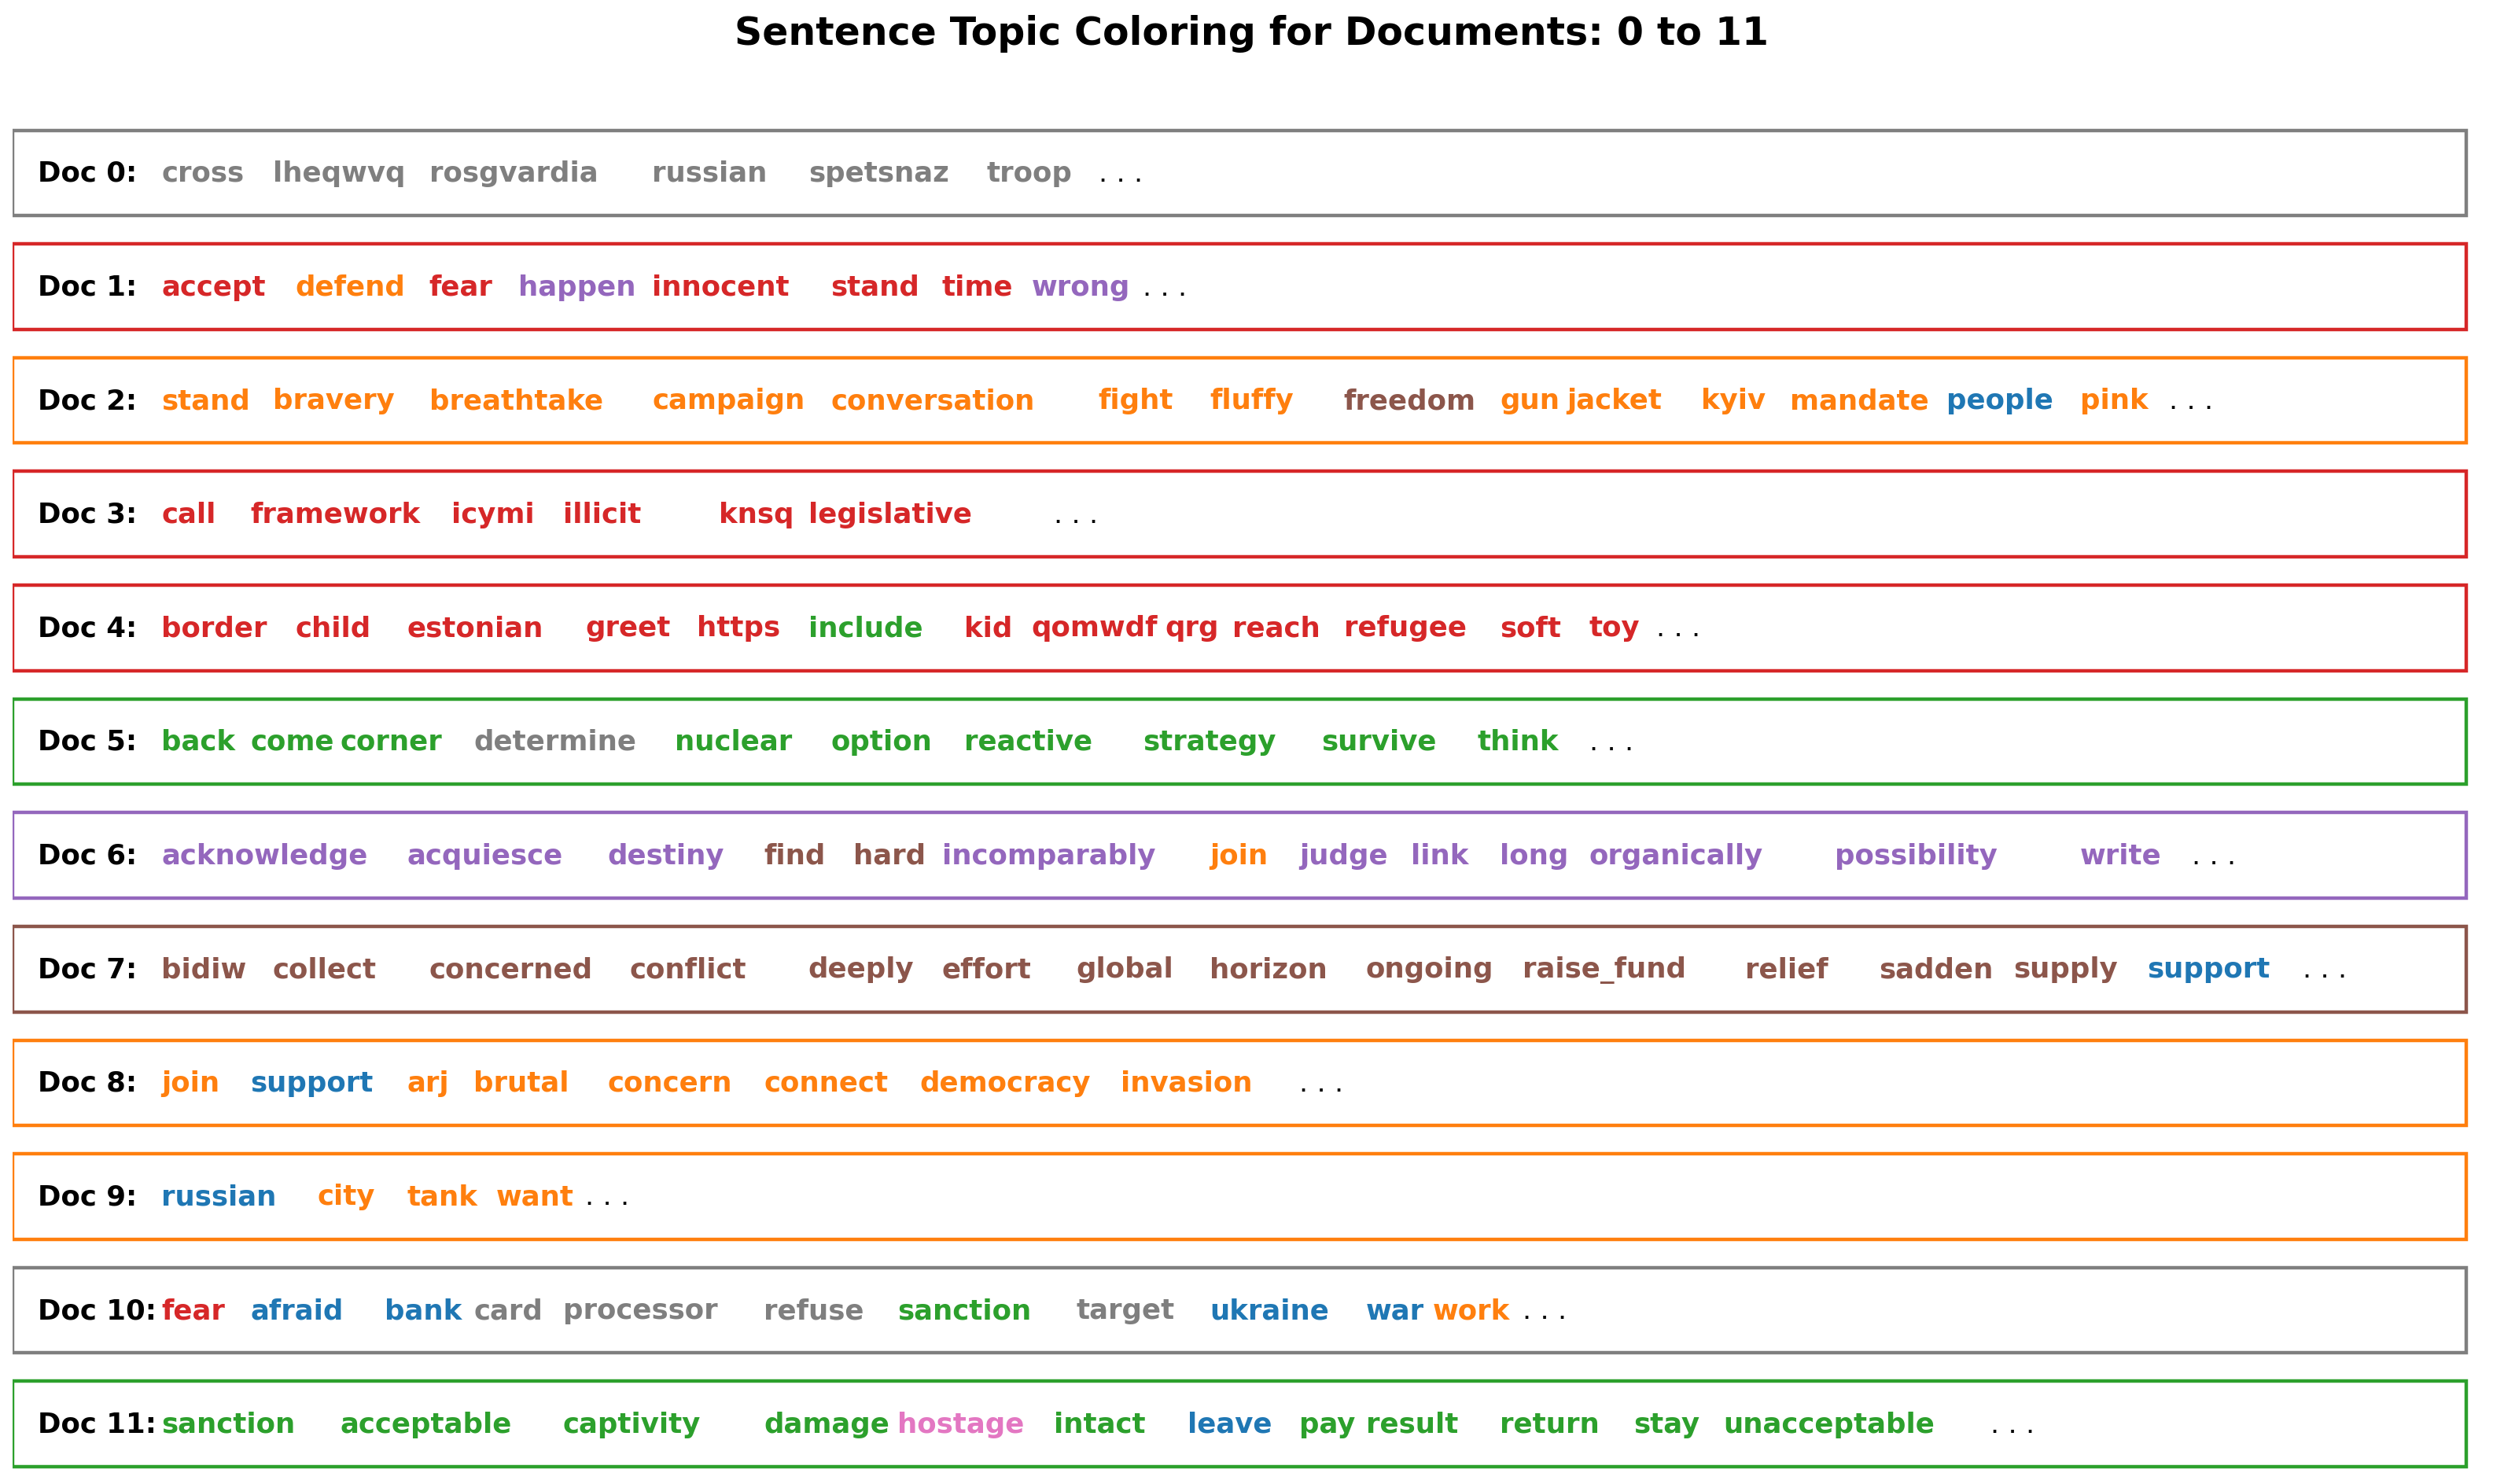

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()   

## 6.  What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=optimal_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:
- The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
- The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

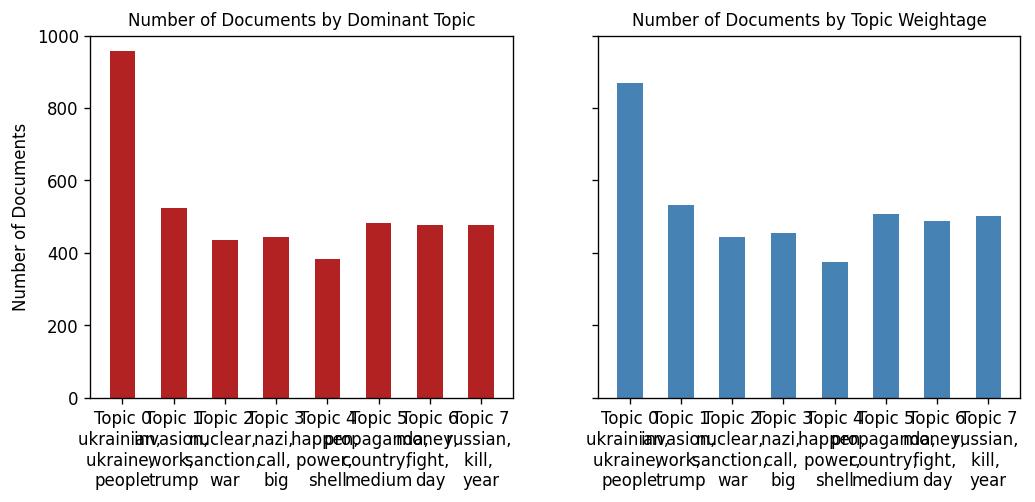

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## 7 . t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2908 samples in 0.005s...
[t-SNE] Computed neighbors for 2908 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2908
[t-SNE] Computed conditional probabilities for sample 2000 / 2908
[t-SNE] Computed conditional probabilities for sample 2908 / 2908
[t-SNE] Mean sigma: 0.000867
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.152016
[t-SNE] KL divergence after 1000 iterations: 0.587361


## 8. pyLDAVis
Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel().

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary=optimal_model.id2word)
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.279739 -0.094676       1        1  19.902941
1      0.126670 -0.239819       2        1  12.724484
7     -0.184671  0.062618       3        1  12.500722
5      0.147552  0.244184       4        1  12.174572
6      0.133628 -0.110949       5        1  11.953362
2     -0.079243  0.116756       6        1  10.966334
3      0.092761  0.051552       7        1  10.823604
4      0.043042 -0.029666       8        1   8.953981, topic_info=            Term        Freq       Total Category  logprob  loglift
158    ukrainian  560.000000  560.000000  Default  30.0000  30.0000
108      ukraine  482.000000  482.000000  Default  29.0000  29.0000
25        people  422.000000  422.000000  Default  28.0000  28.0000
529   propaganda  279.000000  279.000000  Default  27.0000  27.0000
197         nazi  204.000000  204.000000  Default  26.0000  26.0000
58       nuclear  154.000000  154.000000  Default  25.0000  25.0000
3        russian  424.000000  424.000000  Default  24.0000  24.0000
90       support  206.000000  206.000000  Default  23.0000  23.0000
35          call  144.000000  144.000000  Default  22.0000  22.0000
415         kill  150.000000  150.000000  Default  21.0000  21.0000
181      country  187.000000  187.000000  Default  20.0000  20.0000
138        money  122.000000  122.000000  Default  19.0000  19.0000
97      invasion  119.000000  119.000000  Default  18.0000  18.0000
109          war  393.000000  393.000000  Default  17.0000  17.0000
110         work  104.000000  104.000000  Default  16.0000  16.0000
257        trump   99.000000   99.000000  Default  15.0000  15.0000
106     sanction   91.000000   91.000000  Default  14.0000  14.0000
548         year   93.000000   93.000000  Default  13.0000  13.0000
18         fight   93.000000   93.000000  Default  12.0000  12.0000
515         send  113.000000  113.000000  Default  11.0000  11.0000
9         happen   70.000000   70.000000  Default  10.0000  10.0000
441          lie   79.000000   79.000000  Default   9.0000   9.0000
188          day   96.000000   96.000000  Default   8.0000   8.0000
45         https  316.000000  316.000000  Default   7.0000   7.0000
294        power   64.000000   64.000000  Default   6.0000   6.0000
12          time  140.000000  140.000000  Default   5.0000   5.0000
186       attack   75.000000   75.000000  Default   4.0000   4.0000
205     civilian   69.000000   69.000000  Default   3.0000   3.0000
5          troop   73.000000   73.000000  Default   2.0000   2.0000
335       invade   73.000000   73.000000  Default   1.0000   1.0000
25        people  422.118279  422.891722   Topic1  -2.8401   1.6125
90       support  205.544251  206.317418   Topic1  -3.5597   1.6105
515         send  112.315063  113.088489   Topic1  -4.1641   1.6074
116        leave   68.881589   69.655066   Topic1  -4.6530   1.6031
179       leader   66.869956   67.643237   Topic1  -4.6826   1.6028
201         side   64.751408   65.524589   Topic1  -4.7148   1.6024
422         love   55.376808   56.149674   Topic1  -4.8712   1.6004
1058        hate   54.734164   55.507396   Topic1  -4.8829   1.6003
108      ukraine  475.236088  482.146529   Topic1  -2.7216   1.5999
158    ukrainian  552.473837  560.532772   Topic1  -2.5710   1.5998
171      soldier   86.168054   87.427816   Topic1  -4.4291   1.5998
1105         man   52.533360   53.307013   Topic1  -4.9239   1.5997
858        point   45.911292   46.685037   Topic1  -5.0587   1.5976
435         feel   45.177734   45.951205   Topic1  -5.0748   1.5973
704         high   42.988710   43.762930   Topic1  -5.1244   1.5965
981       occupy   41.030925   41.805294   Topic1  -5.1711   1.5956
1215        lead   39.652520   40.426002   Topic1  -5.2052   1.5950
1234   terrorist   38.517853   39.291677   Topic1  -5.2343   1.5944
408        story   37.655234   38.429022   Topic1  -5.2569   1.5940
495         flag 

# Conclusion
We started from scratch by importing, cleaning and processing the newsgroups dataset to build the LDA model. Then we saw multiple ways to visualize the outputs of topic models including the word clouds and sentence coloring, which intuitively tells you what topic is dominant in each topic. A t-SNE clustering and the pyLDAVis are provide more details into the clustering of the topics.